In [9]:
# Standard library imports
import os
import sys

# Contributed library imports
import geopandas as gpd
import numpy as np
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

sys.path.append("../..")
from constants import (
    get_IDs_to_labels,
    get_numpy_export_cf_filename,
    get_predicted_vector_labels_filename,
    get_predicted_polygons_labels_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    get_numpy_export_faces_texture_filename,
    LABELS_COLUMN,
    LABELS_FILENAME,
)

# Set constants
You should be able to define most of the behavior from these constants

In [10]:
PREDICTION_SITE = "lassic"
TRAINING_SITES = sorted(["chips", "delta"])

In [11]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

/ofo-share/repos-david/conda/envs/MVMT-dev2/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/ofo-share/repos-david/conda/envs/MVMT-dev2/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-dev2/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

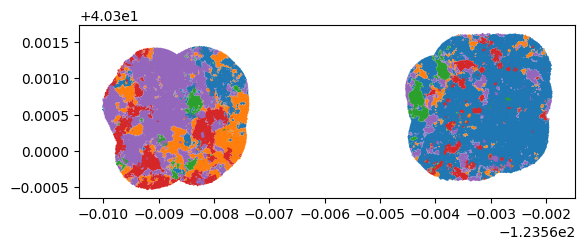

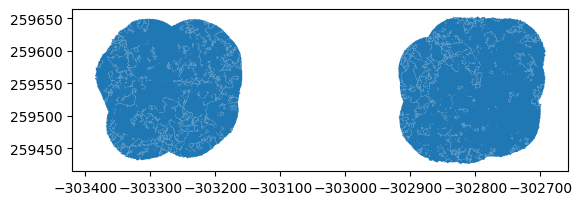

In [12]:
PREDICTED_VECTOR_LABELS_FILE = get_predicted_vector_labels_filename(PREDICTION_SITE, TRAINING_SITES)

df = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
df.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5)

class_fractions, IDs_in_original, unique_class_names = get_overlap_vector(
    unlabeled_df=LABELS_FILENAME,
    classes_df=PREDICTED_VECTOR_LABELS_FILE,
    class_column="class_ID",
)

[[4.92467344e+00 2.34599522e+01 0.00000000e+00 3.60211935e+00
  3.32694664e+01]
 [9.48574806e+00 1.42465470e+01 2.50185752e-02 0.00000000e+00
  2.10296054e+01]
 [6.97103487e+00 6.97048654e-01 0.00000000e+00 0.00000000e+00
  1.57419564e+00]
 [2.47536957e+01 9.23224028e-01 0.00000000e+00 6.30467975e-01
  3.06490279e+01]
 [4.45704934e+01 0.00000000e+00 3.24893573e-01 4.67847336e-01
  2.86138120e+01]
 [7.98799216e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.67624460e-01]
 [2.98336143e+01 0.00000000e+00 1.56143990e+00 8.50631509e-02
  5.53094946e+00]
 [2.23114951e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.45710823e+00]
 [1.28956331e+00 6.19269172e-02 1.44247722e+00 0.00000000e+00
  1.34463126e+01]
 [3.55550389e+01 6.40882244e+00 0.00000000e+00 0.00000000e+00
  4.41166481e-01]
 [2.47185009e+01 0.00000000e+00 2.35539861e+00 0.00000000e+00
  3.73282967e+00]
 [2.95663975e+01 1.66035513e+00 0.00000000e+00 3.77032658e+00
  4.43622491e+00]
 [3.33611504e+01 1.07804424e+00 1.965116

/ofo-share/repos-david/conda/envs/MVMT-dev2/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

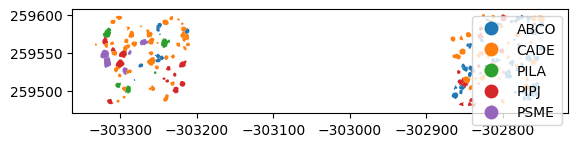

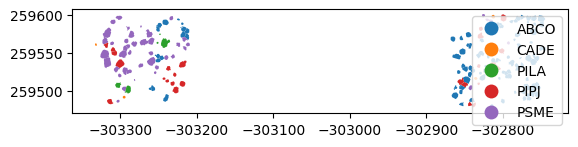

In [13]:
IDs_TO_LABELS = get_IDs_to_labels()

print(class_fractions)
print(IDs_in_original)
print(unique_class_names)
pred_IDs = np.argmax(class_fractions, axis=1)

pred_IDs = [int(unique_class_names[i]) for i in pred_IDs]
pred_class = [IDs_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABELS_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

In [14]:
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = get_numpy_export_cf_filename(PREDICTION_SITE, training_sites=TRAINING_SITES, is_ortho=False)

gt_list = site_gdf[LABELS_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

cf, classes, accuracy = compute_and_show_cf(
    pred_labels=pred_list,
    gt_labels=gt_list,
    labels=list(IDs_TO_LABELS.values()),
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)
print(f"Accuracy: {accuracy}")

TypeError: get_numpy_export_cf_filename() missing 2 required positional arguments: 'training_sites' and 'is_ortho'

# Ground truth classes

In [ ]:
MESH_FILENAME = get_mesh_filename(PREDICTION_SITE)
CAMERAS_FILENAME = get_camera_filename(PREDICTION_SITE)
DTM_FILE = get_DTM_filename(PREDICTION_SITE)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Per-polygon labeling using the mesh from above for convenience

In [ ]:
predicted_face_classes_filename = get_numpy_export_faces_texture_filename()
# %%
predicted_face_classes = np.load()

ground_mask = mesh.get_height_above_ground(
    DTM_file=DTM_FILE,
    threshold=HEIGHT_ABOVE_GROUND_THRESH,
)
ground_mask_faces = mesh.vert_to_face_texture(ground_mask)

# Ground points get a weighting of 0.01, others get 1
weighting = 1 - 0.99 * ground_mask_faces.astype(float)

polygons = gpd.read_file(LABELS_FILENAME).query("fire==@PREDICTION_SITE")

predicted_filename = get_predicted_polygons_labels_filename(PREDICTION_SITE, TRAINING_SITES, False)

predicted_class_labels = mesh.label_polygons(predicted_face_classes, polygons, face_weighting=weighting)
polygons["predicted_labels"] = predicted_class_labels
polygons.to_file(predicted_filename)

# Predicted classes

In [ ]:
NUMPY_EXPORT_FACES_TEXTURE_FILE= get_numpy_export_cf_filename(PREDICTION_SITE)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=NUMPY_EXPORT_FACES_TEXTURE_FILE,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

# Colored mesh

In [ ]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)